<a href="https://colab.research.google.com/github/GeorgeShmelin/Masterschool_Project_Computer_Vision/blob/main/CNN_CV__project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# For reproducibility
# np.random.seed(42)

In [2]:
import gc # gc.collect() are for rubbish collection

In [3]:
# from sklearn.model_selection import train_test_split

## import tensorflow as tf
TensorFlow is the deep learning framework I’ll be using.
It gives me access to models, layers, training tools, and datasets like CIFAR-10.

In [4]:
!pip install tensorflow
!pip install opencv-python

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.utils import to_categorical

In [7]:
!pip install keras

In [8]:
from keras.models import Sequential
from keras.datasets import mnist

%matplotlib inline

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Dataset

In [10]:
from tensorflow.keras.datasets import cifar10

# This automatically downloads and loads the data
# Load CIFAR-10 dataset

In [11]:
import urllib.request

try:
    urllib.request.urlopen('https://www.google.com', timeout=5)
    print("Successfully connected to Google.")
except Exception as e:
    print(f"Could not connect to Google: {e}")

Successfully connected to Google.


In [12]:
from tensorflow.keras.applications import ResNet50

In [13]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
n = 15000

train_images = train_images[:n]
train_labels = train_labels[:n]

In [15]:
print ("The number of training examples is: ", train_images.shape[0])
print ("The number of test examples is: ", test_images.shape[0])
print ("The size of every img is: ", train_images.shape[1:])
num_classes=len(np.unique(train_labels))
print ("The number of classes is: ", num_classes)

The number of training examples is:  15000
The number of test examples is:  10000
The size of every img is:  (32, 32, 3)
The number of classes is:  10


In [16]:
# Reshaping the input to be a vector instead of an array
dim_array=np.prod(train_images.shape[1:])
train_data=train_images.reshape(train_images.shape[0],dim_array)
test_data=test_images.reshape(test_images.shape[0],dim_array)

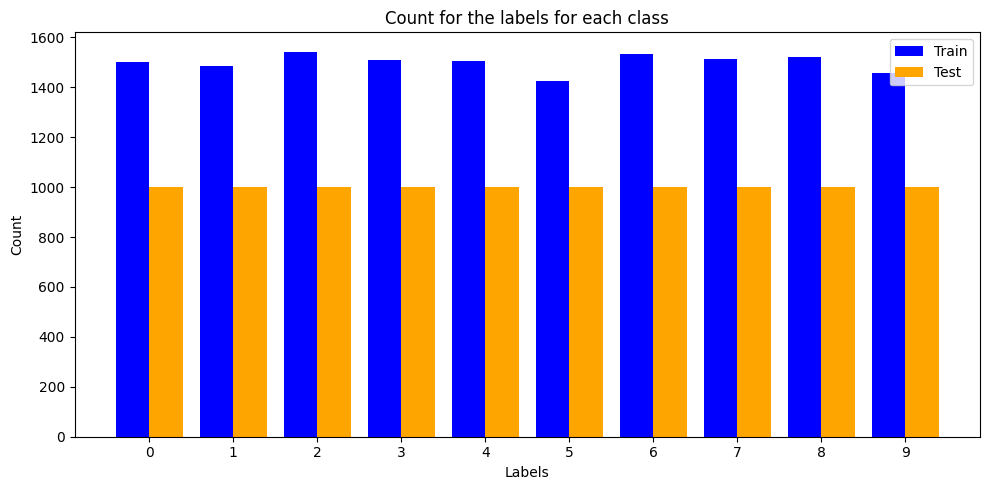

In [17]:
# Count label occurrences
train_counts = pd.Series(train_labels.flatten()).value_counts().sort_index()
test_counts = pd.Series(test_labels.flatten()).value_counts().sort_index()

# Plot label distribution
labels = train_counts.index
x = np.arange(len(labels))
bar_width = 0.4

plt.figure(figsize=(10, 5))
plt.bar(x, train_counts, width=bar_width, label='Train', color='blue')
plt.bar(x + bar_width, test_counts, width=bar_width, label='Test', color='orange')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count for the labels for each class')
plt.xticks(x + bar_width / 2, labels)
plt.legend()
plt.tight_layout()
plt.show()

## data overview

build a list that will contain the classes

In [18]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [19]:
def plot_image(i):
    image = train_images[i]
    label = train_labels.flatten()[i]

    cl = classes[label]

    plt.imshow(image)
    plt.title(cl)

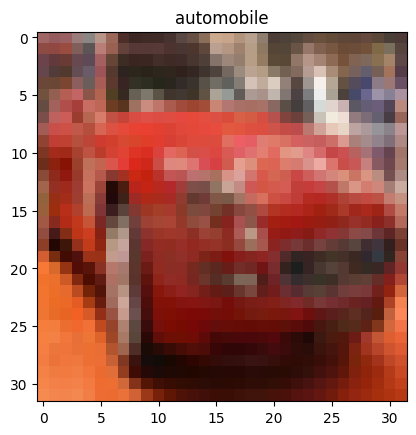

In [20]:
plot_image(5)

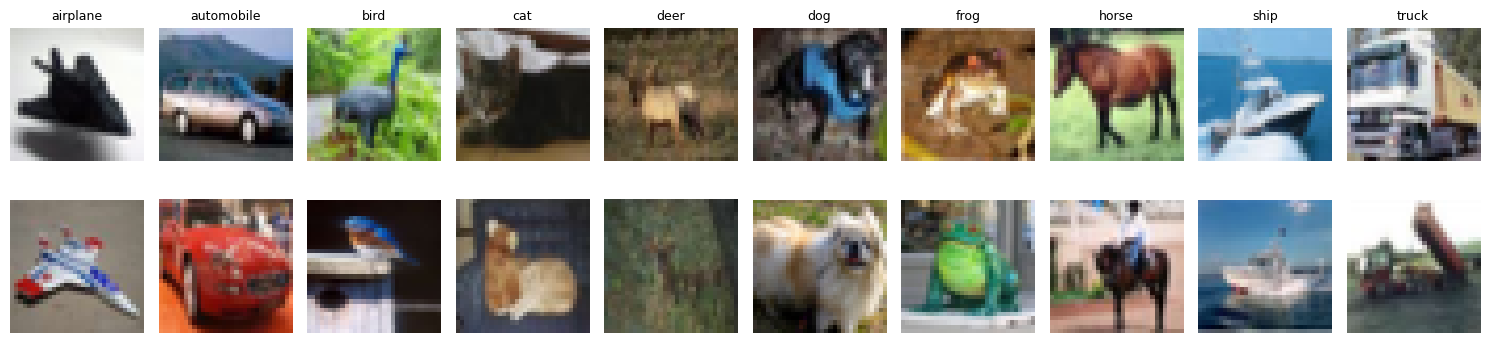

In [21]:
# Flatten labels for indexing
flat_labels = train_labels.flatten()

# Get one example for each class (twice)
top_indices = []
bottom_indices = []

for class_idx in range(10):
    indices = np.where(flat_labels == class_idx)[0]
    top_indices.append(indices[0])       # First image of the class
    bottom_indices.append(indices[1])    # Second image of the class

# Plot 2 rows × 10 columns
plt.figure(figsize=(15, 4))
for col in range(10):
    # Top row (with label)
    plt.subplot(2, 10, col + 1)
    plt.imshow(train_images[top_indices[col]])
    plt.title(classes[col], fontsize=9)
    plt.axis('off')

    # Bottom row (no label)
    plt.subplot(2, 10, 10 + col + 1)
    plt.imshow(train_images[bottom_indices[col]])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model

In [22]:
# Convert images to png (scale from 0 to 1)
train_data=train_data.astype('float32')
test_data=test_data.astype('float32')

train_data/=255
test_data/=255

In [23]:
#Converting labels to one-hot encoding form
# from tensorflow.keras.utils import to_categorical

train_labels_one_hot=to_categorical(train_labels)
test_labels_one_hot=to_categorical(test_labels)

In [24]:
print("Before encoding",train_labels[5])
print("After encoding",train_labels_one_hot[5])

Before encoding [1]
After encoding [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


my model

In [27]:
# 1. Load ResNet50 (WITHOUT the top layer), use input shape from CIFAR-10
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(32, 32, 3)))

# 2. Freeze base model layers (yoI can unfreeze some later if needed)
for layer in base_model.layers:
    layer.trainable = False

# 3. Add my own classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)      # or Flatten()
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 6. Train and assign the History object to the 'history' variable
history = model.fit(
    train_images, train_labels_one_hot,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_178']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.4020 - loss: 1.9718 - val_accuracy: 0.5427 - val_loss: 1.3281
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6091 - loss: 1.0999 - val_accuracy: 0.5577 - val_loss: 1.2978
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6900 - loss: 0.8920 - val_accuracy: 0.5657 - val_loss: 1.3333
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7356 - loss: 0.7450 - val_accuracy: 0.5770 - val_loss: 1.3481
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7746 - loss: 0.6361 - val_accuracy: 0.5703 - val_loss: 1.3872


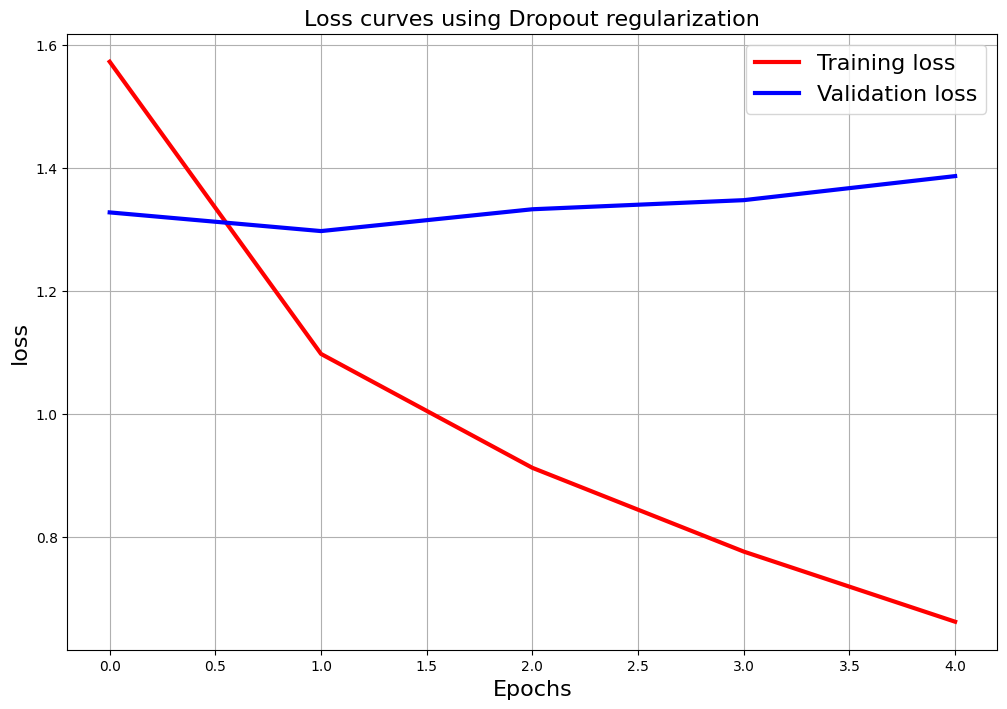

In [28]:
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Loss curves using Dropout regularization',fontsize=16)
plt.grid()

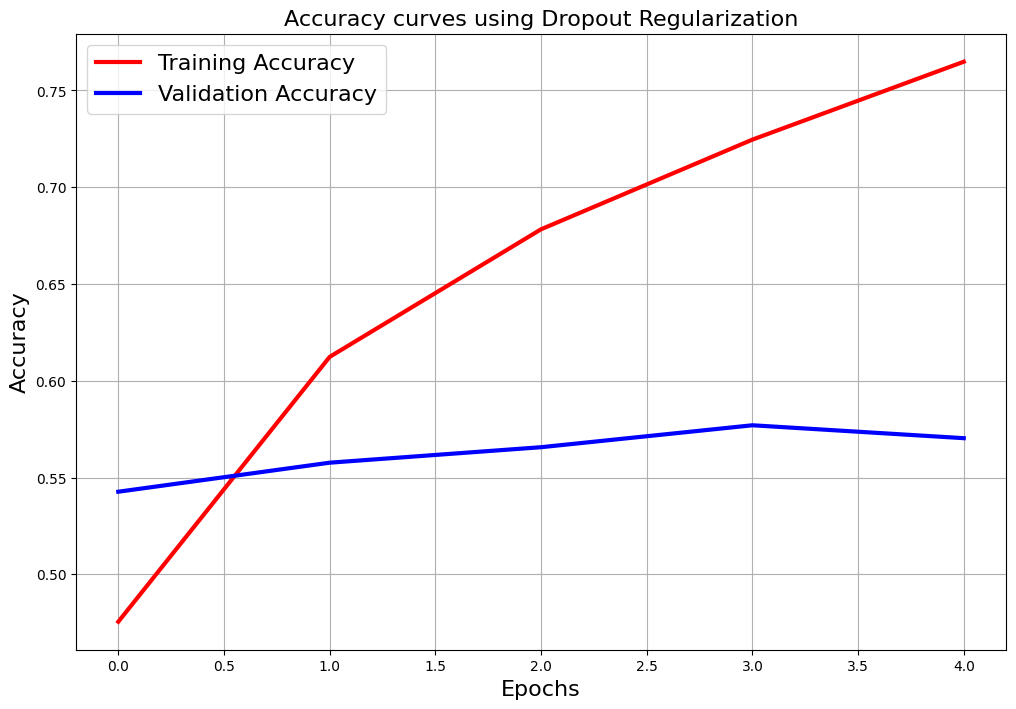

In [29]:
plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy curves using Dropout Regularization',fontsize=16)
plt.grid()

## Unfreeze some layers later

In [30]:
# Unfreeze last few layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Re-compile before re-training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# 1. Load ResNet50 (WITHOUT the top layer), use input shape from CIFAR-10
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(32, 32, 3)))

# 2. Freeze base model layers (yoI can unfreeze some later if needed)
for layer in base_model.layers:
    layer.trainable = False

# 3. Add my own classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)      # or Flatten()
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 6. Train and assign the History object to the 'history' variable
history = model.fit(
    train_images, train_labels_one_hot,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_356']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3897 - loss: 2.1332 - val_accuracy: 0.5353 - val_loss: 1.3482
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6183 - loss: 1.0950 - val_accuracy: 0.5580 - val_loss: 1.3101
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6727 - loss: 0.9227 - val_accuracy: 0.5593 - val_loss: 1.3082
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7358 - loss: 0.7645 - val_accuracy: 0.5547 - val_loss: 1.3495
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7735 - loss: 0.6411 - val_accuracy: 0.5593 - val_loss: 1.3771
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8186 - loss: 0.5333 - val_accuracy: 0.5667 - val_loss: 1.4376
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8608 - loss: 0.4278 - val_accuracy: 0.5633 - val_loss: 1.5359
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8856 - loss: 0.3568 - val_accuracy: 0.5

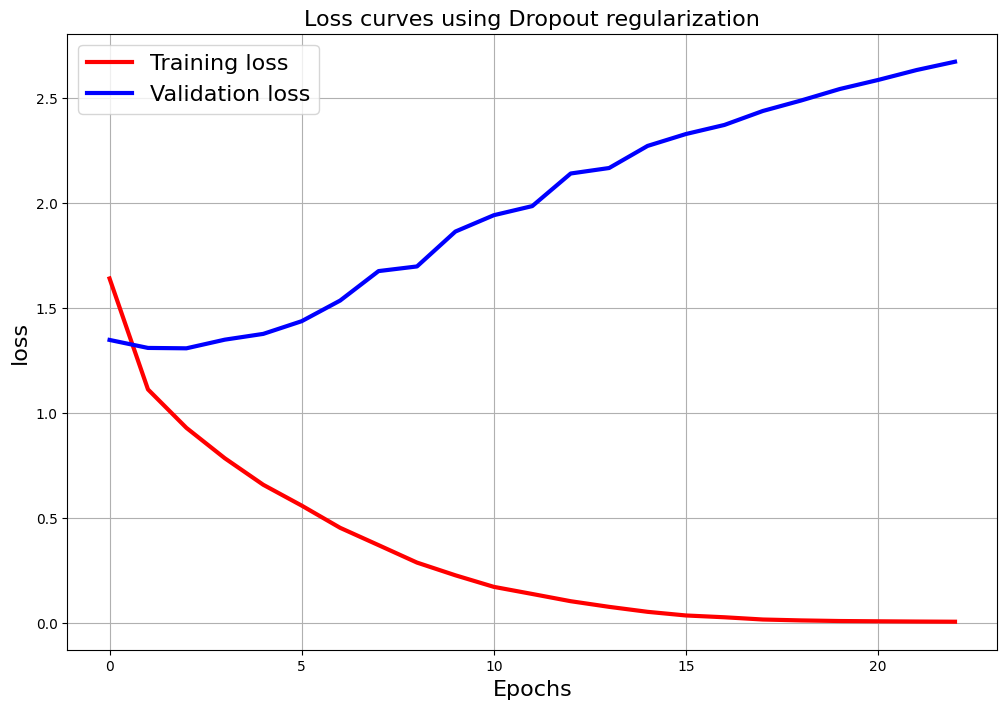

In [32]:
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Loss curves using Dropout regularization',fontsize=16)
plt.grid()

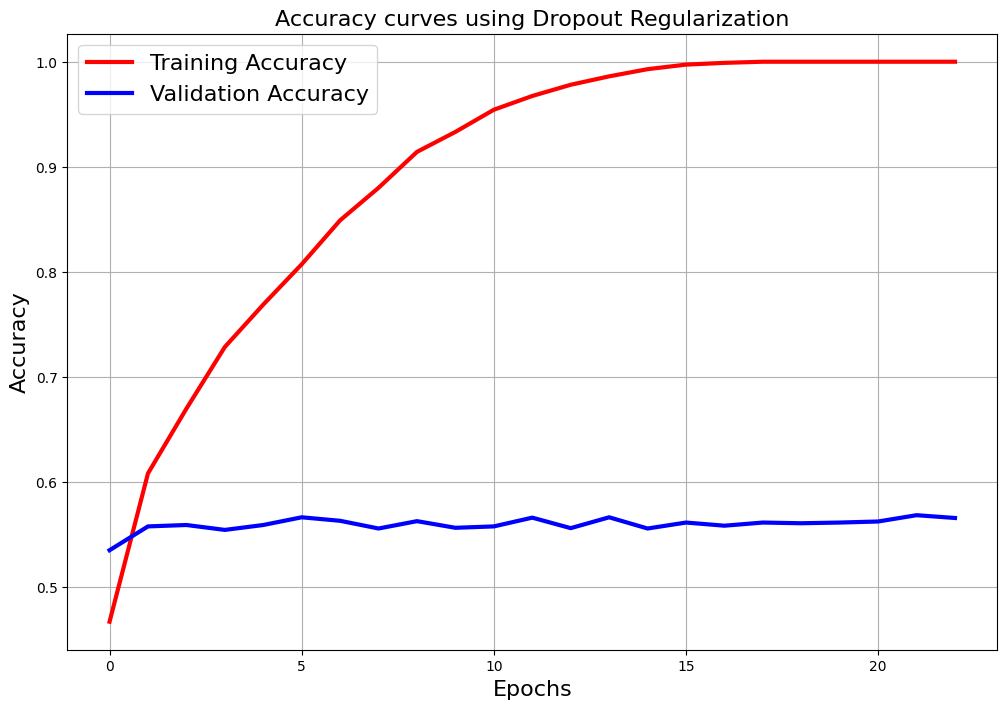

In [33]:
plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy curves using Dropout Regularization',fontsize=16)
plt.grid()

In [36]:
# 1. Input layer (original image size)
input_layer = Input(shape=(32, 32, 3))

# 2. Load ResNet50 (WITHOUT the top layer), use input shape from CIFAR-10
# We will directly apply ResNet to the input_layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer) # Use input_layer here

# 3. Freeze base model layers (you can unfreeze some later if needed)
for layer in base_model.layers:
    layer.trainable = False

# 4. Get the output of the base model (the feature maps)
x = base_model.output

# 5. Add my own classification layers on top of the base model's output
x = GlobalAveragePooling2D()(x)      # or Flatten()
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

# 6. Build the final model
model = Model(inputs=base_model.input, outputs=output) # Model inputs are the base_model inputs

# 7. Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 8. Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 9. Train and assign the History object to the 'history' variable
history = model.fit(
    train_images, train_labels_one_hot,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.3993 - loss: 1.9918 - val_accuracy: 0.5260 - val_loss: 1.3879
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6198 - loss: 1.0957 - val_accuracy: 0.5660 - val_loss: 1.3121
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6776 - loss: 0.9073 - val_accuracy: 0.5640 - val_loss: 1.3099
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7322 - loss: 0.7431 - val_accuracy: 0.5643 - val_loss: 1.3942
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7893 - loss: 0.6227 - val_accuracy: 0.5620 - val_loss: 1.4047
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8282 - loss: 0.5035 - val_accuracy: 0.5510 - val_loss: 1.4888
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8651 - loss: 0.4127 - val_accuracy: 0.5723 - val_loss: 1.5072
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8952 - loss: 0.3332 - val_accuracy: 0.56

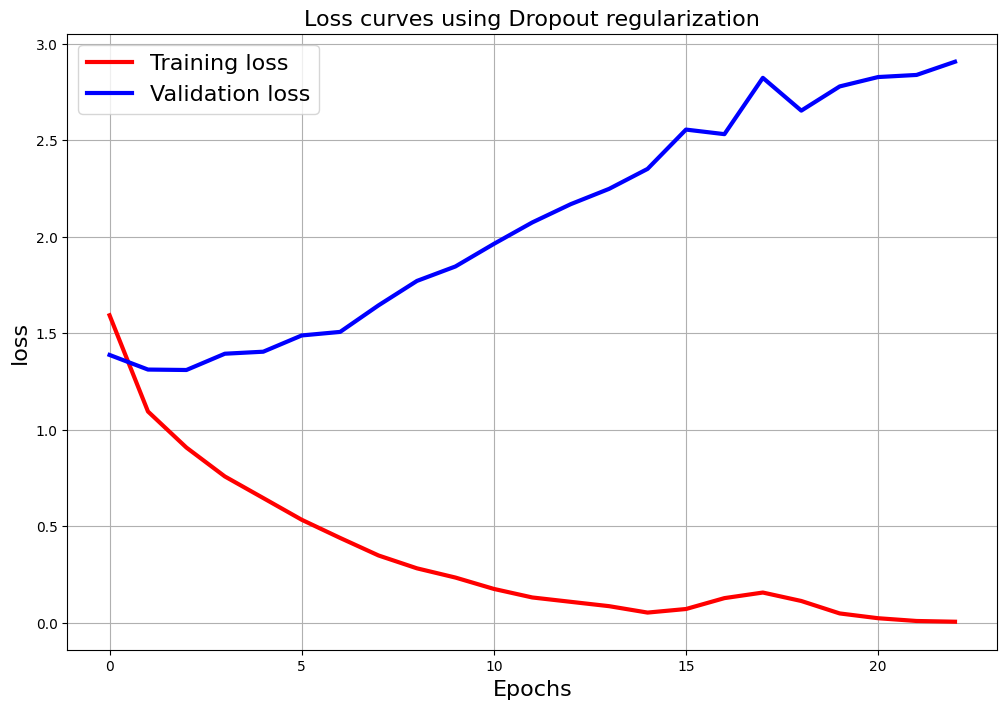

In [37]:
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Loss curves using Dropout regularization',fontsize=16)
plt.grid()

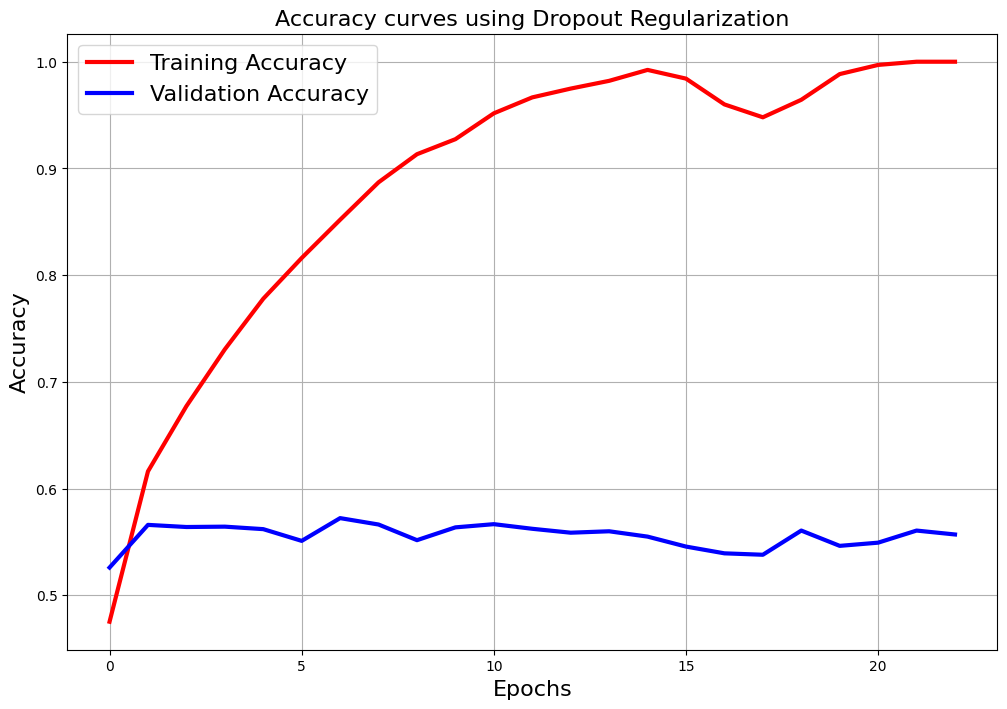

In [38]:
plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy curves using Dropout Regularization',fontsize=16)
plt.grid()

## Display a results table

In [40]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot, verbose=0)

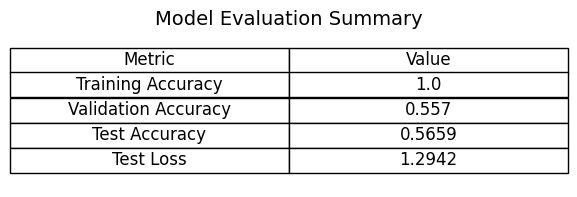

In [41]:
# import matplotlib.pyplot as plt

# Collect results
results = {
    "Metric": ["Training Accuracy", "Validation Accuracy", "Test Accuracy", "Test Loss"],
    "Value": [
        round(history.history['accuracy'][-1], 4),
        round(history.history['val_accuracy'][-1], 4),
        round(test_accuracy, 4),
        round(test_loss, 4)
    ]
}

# Create a table plot
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=list(zip(results["Metric"], results["Value"])),
                 colLabels=["Metric", "Value"],
                 cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title("Model Evaluation Summary", fontsize=14)
plt.show()